<a href="https://colab.research.google.com/github/wonjae124/2021_Lab_project/blob/main/Gn_strong_DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/model
!pwd

Mounted at /content/drive
/content/drive/MyDrive/model
/content/drive/MyDrive/model


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch
import torchvision
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch import nn
import torch.optim as optim
from tqdm import tqdm
import skimage.util.noise as noise 
import math
import pytorch_ssim

In [3]:
def get_psnr(input, output, max_val=1):

    input = input.cpu().detach().numpy()
    output = output.cpu().detach().numpy()
    img_diff = output - input
    rmse = np.mean(img_diff**2)
    
    if rmse == 0:
      return 100
    else:
      psnr = 10 * math.log10( (max_val**2)/rmse)
      return psnr 

In [4]:
# 훈련 데이터, 검증 데이터, 테스트 데이터순으로 5000개, 10000개, 10000개
tr_dataset = datasets.MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()) 
tr_subset, val_subset = torch.utils.data.random_split(tr_dataset, [50000,10000], generator=torch.Generator().manual_seed(1))
test_set  = torchvision.datasets.MNIST(root='./data', train=False, download=True,transform=transforms.ToTensor())

num_workers= 2
batch_size = 256

In [5]:
X_train_set = tr_subset.dataset.data[tr_subset.indices]
Y_train_set = tr_subset.dataset.targets[tr_subset.indices]
X_val_set = val_subset.dataset.data[val_subset.indices]
Y_val_set = val_subset.dataset.targets[val_subset.indices]

train_loader = torch.utils.data.DataLoader(tr_subset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_subset, batch_size=batch_size)

In [6]:
print(len(train_loader)) # 1epoch당 196개의 minibatch(iteration) update 진행
print(len(valid_loader)) #1epoch당 1epoch당 40개의 미니배치로 val_loss를 측정함. update X

196
40


In [7]:
train_set_arr = X_train_set.numpy() #numpy 자료형(ndarray) 변환
val_set_arr = X_val_set.numpy()

In [8]:
#numpy
Gn_strong_train_set_arr = noise.random_noise(X_train_set,mode='gaussian',seed=None, clip=False, mean=0.75) 
Gn_strong_val_set_arr = noise.random_noise(X_val_set,mode='gaussian',seed=None, clip=False, mean=0.75) 

In [9]:
Gn_strong_train = torch.from_numpy(Gn_strong_train_set_arr).float().div(255.0).unsqueeze(1)
Gn_strong_val = torch.from_numpy(Gn_strong_val_set_arr).float().div(255.0).unsqueeze(1)



Gn_moderate_train = torch.from_numpy(Gn_moderate_train_arr).float().div(255.0).unsqueeze(1)
Gn_moderate_test = torch.from_numpy(Gn_week_val_set_arr).float().div(255.0).unsqueeze(1)

Gn_strong_train = torch.from_numpy(Gn_strong_train_arr).float().div(255.0).unsqueeze(1)
Gn_strong_test = torch.from_numpy(Gn_week_val_set_arr).float().div(255.0).unsqueeze(1)


In [10]:
Custom_Gn_strong_train = []
for i in range(len(Gn_strong_train)):
  Custom_Gn_strong_train.append([Gn_strong_train[i],Y_train_set[i]])

  
Custom_Gn_strong_train_loader = DataLoader(Custom_Gn_strong_train,batch_size=batch_size)

Custom_Gn_strong_val = []

for i in range(len(Gn_strong_val)):
  Custom_Gn_strong_val.append([Gn_strong_val[i],Y_val_set[i]])
  
Custom_Gn_strong_val_loader = DataLoader(Custom_Gn_strong_val,batch_size=batch_size)

In [11]:
class Encoder(nn.Module):   

  def __init__(self, encoded_space_dim,fc2_input_dim): 
    super().__init__()

    self.encoder_cnn = nn.Sequential( 
        
        #1, 28, 28 
        nn.Conv2d(in_channels = 1,out_channels = 8,kernel_size = 3, stride = 2, padding = 1),
        #8, 14, 14               #https://machine-geon.tistory.com/46
        nn.ReLU(True), 

         
        nn.Conv2d(in_channels = 8,out_channels = 16,kernel_size = 3, stride=2, padding = 1), 
        #16, 7, 7
        nn.BatchNorm2d(16), 
        nn.ReLU(True),
        
        nn.Conv2d(in_channels = 16,out_channels = 32,kernel_size = 3, stride=2, padding=0),
        #32, 3, 3
        nn.ReLU(True)
    )

    self.flatten = nn.Flatten(start_dim=1) 
    # 32 X 3 X 3 -> v

    self.encoder_lin = nn.Sequential( 
        nn.Linear(3*3*32,fc2_input_dim), #288 -> 128
        nn.ReLU(True),
        nn.Linear(fc2_input_dim, encoded_space_dim) #128->4 
    )

  def forward(self, x): #출력
    x = self.encoder_cnn(x) 
    x = self.flatten(x)
    x = self.encoder_lin(x)
    return x

In [12]:
class Decoder(nn.Module): 
                          
  def __init__(self, encoded_space_dim, fc2_input_dim):
    super().__init__() 
    self.decoder_lin = nn.Sequential( 
        nn.Linear(encoded_space_dim, fc2_input_dim), #4 -> 128
        nn.ReLU(True),
        nn.Linear(fc2_input_dim, 3*3*32), #128 -> 256 
        nn.ReLU(True)
    )

    self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32,3,3))
     # 256 -> 32,3,3    
    self.decoder_conv = nn.Sequential(  
        nn.ConvTranspose2d(in_channels = 32, out_channels = 16, kernel_size = 3,
        stride=2, output_padding=0),
         #16,7,7 
        nn.BatchNorm2d(16),
        nn.ReLU(True),

        nn.ConvTranspose2d(in_channels = 16, out_channels = 8, kernel_size=3, 
       stride= 2, padding=1, output_padding=1), 
       #8, 14, 14
        nn.BatchNorm2d(8),
        nn.ReLU(True),
        nn.ConvTranspose2d(in_channels = 8, out_channels =1,  kernel_size = 3,
        stride=2, padding=1, output_padding=1)  
        #1, 28, 28
    )
     
  def forward(self, x): 
    x = self.decoder_lin(x)
    x = self.unflatten(x)
    x = self.decoder_conv(x)
    x = torch.sigmoid(x) #마지막에 sigmoid를 넣어서 원래의 이미지로 복원한다.
    return x  

In [13]:
lr = 0.001
torch.manual_seed(0) #manual_seed로 랜덤 난수를 고정함.
d=4

encoder = Encoder(encoded_space_dim=d, fc2_input_dim=128) #처음에 4차원으로 세팅함. 32,1,28,28로 입력값으로 입력시킬 예정이다. [batch,channel.height,width] 
decoder = Decoder(encoded_space_dim=d, fc2_input_dim=128) 

In [14]:
loss_fn = torch.nn.MSELoss()

params_to_optimize = [ 
  {'params' : encoder.parameters()},  #모델마다 각각의 learning_rate를 설정 
  {'params' : decoder.parameters()}   
]

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
print('Selected device : {%s}' % device)

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05) 
#weight_decay는 overfitiing 방지 용도임. 최적화 할 때 L2 penalty를 부여해서 loss를 최소화 한다.(Lasso 정규화 참고) 

encoder.to(device) 
decoder.to(device) 

Selected device : {cuda}


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [15]:
def AE_train_epoch_den(encoder,decoder, device, dataloader,dataloader_hat,loss_fn, optimizer):
  encoder.train() 
  decoder.train()

  for i,(origin,noisy) in enumerate(zip(dataloader,dataloader_hat)):
    origin_img,_ = origin 
    corrupted_img,_ = noisy

    origin_img = origin_img.to(device)
    corrupted_img=corrupted_img.to(device)

    encoded_data = encoder(corrupted_img)
    decoded_data = decoder(encoded_data)
    loss = loss_fn(decoded_data, origin_img)

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step()
    
                                                            
                                                            
  return loss.data

In [16]:
def AE_test_epoch_den(encoder, decoder, device, dataloader,dataloader_hat,loss_fn):
    encoder.eval() #train 하지 않고 대신에 evaluation mode사용. 테스트 데이터만 가지고 비교 할 것이기 때문임
    decoder.eval() 
    with torch.no_grad(): #with을 써서 gradient 계산을 막아준다.(required_grad=False와 같음). 학습을 하지 않기 때문에 no.grad()일 수 있다.
      conc_out = [] #리스트 자료형 가져옴 
      conc_label = []
      for i,(origin,noisy) in enumerate(zip(dataloader,dataloader_hat)):
        origin_img,_ = origin 
        corrupted_img,_ = noisy
        origin_img = origin_img.to(device)
        corrupted_img=corrupted_img.to(device)    
      
        encoded_data = encoder(corrupted_img)
        decoded_data = decoder(encoded_data)
        
        conc_out.append(decoded_data.cpu()) #decoded_data를 cpu 메모리에 복사하고 이 값을 conc_out 변수에 객체를 추가한다. 
        conc_label.append(origin_img.cpu())  #원본이미지를 conc_label에 추가시켜준다. 쿠다에서 복사해온다.
                                              #문자열 추가함수 append이다. 텐서의 차원을 추가하려면 cat을 쓴다.

      conc_out = torch.cat(conc_out) #concatenate(텐서를 결합하는 함수)다. 반환은 당연히 텐서다. 차원증가와 함께 실제 값이 추가 된다. dim=0이 default이다.
      conc_label = torch.cat(conc_label)

      val_loss = loss_fn(conc_out, conc_label) # loss 비교는 원본이미지 
    return val_loss.data #val_loss반환값이 test_epoch_den 함수인지 아니면 torch.no_grad()함수인지 모르겠다

In [17]:
def plot_ae_outputs_den(encoder, decoder, n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_set.targets.numpy() 
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}    
    for i in range(n):
    
      ax = plt.subplot(3, n, i+1)
      img = test_set[t_idx[i]][0].unsqueeze(0)     
      Noisy_image_arr = noise.random_noise(img,mode='gaussian',mean=0.75)
      Noisy_image = torch.from_numpy(Noisy_image_arr).float().div(255.0)
      torch.reshape(Noisy_image, (1,28,28))
      Noisy_image = Noisy_image.to(device)
      img = img.to(device)

      
      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(Noisy_image))
         psnr = get_psnr(img, rec_img, max_val = 1.)
         ssim = (pytorch_ssim.ssim(img, rec_img).data)
         print("%d => pnsr  :%.3f, ssim :%f"%(i,psnr, ssim))

      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)  
      ax.get_yaxis().set_visible(False)  
 #     if i == n//2:
 #       ax.set_title('Original images')
      ax = plt.subplot(3, n, i + 1 + n)
      plt.imshow(Noisy_image.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)  
      ax.get_yaxis().set_visible(False)  
 #     if i == n//2:
 #       ax.set_title('Corrupted images')

      ax = plt.subplot(3, n, i + 1 + n + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)  
      ax.get_yaxis().set_visible(False)  
#     ax.yticks('ssim:'+str(pytorch_ssim.ssim(img, rec_img).data))
      
#      if i == n//2: # 나누기 후 소수점 부분을 버린다.
#         ax.set_title('Reconstructed images')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.7, 
                    top=0.9, 
                    wspace=0.3, 
                    hspace=0.3)     
    plt.show()

In [18]:
##Training Cycle
num_epochs = 25
history_da = {'train_loss':[], 'val_loss':[]}
print(history_da)

{'train_loss': [], 'val_loss': []}


EPOCH 1/25

 EPOCH 1/25 	 train loss 0.073 	 val loss 0.079
0 => pnsr  :9.511, ssim :0.041107
1 => pnsr  :12.994, ssim :0.038134
2 => pnsr  :9.911, ssim :0.010414
3 => pnsr  :9.731, ssim :0.035751
4 => pnsr  :11.328, ssim :0.035922
5 => pnsr  :10.056, ssim :0.041681
6 => pnsr  :10.424, ssim :0.015012
7 => pnsr  :12.164, ssim :0.074835
8 => pnsr  :10.202, ssim :0.048165
9 => pnsr  :11.703, ssim :0.044747


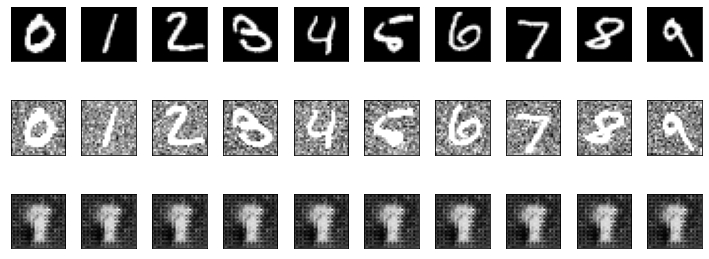

EPOCH 2/25

 EPOCH 2/25 	 train loss 0.053 	 val loss 0.062
0 => pnsr  :11.485, ssim :0.165970
1 => pnsr  :14.304, ssim :0.063153
2 => pnsr  :11.835, ssim :0.172129
3 => pnsr  :11.414, ssim :0.162115
4 => pnsr  :13.046, ssim :0.132846
5 => pnsr  :10.981, ssim :0.101309
6 => pnsr  :11.846, ssim :0.129453
7 => pnsr  :13.346, ssim :0.121650
8 => pnsr  :11.851, ssim :0.129695
9 => pnsr  :12.652, ssim :0.082126


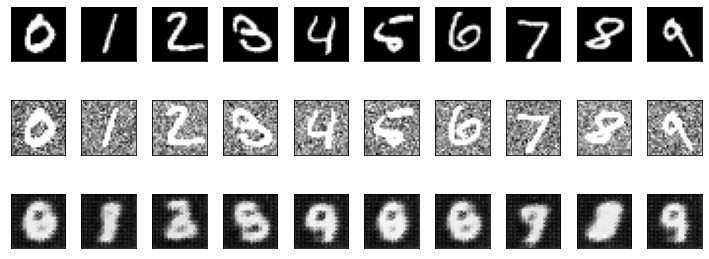

EPOCH 3/25

 EPOCH 3/25 	 train loss 0.048 	 val loss 0.061
0 => pnsr  :11.996, ssim :0.214748
1 => pnsr  :13.971, ssim :0.079572
2 => pnsr  :11.564, ssim :0.171287
3 => pnsr  :11.547, ssim :0.196401
4 => pnsr  :12.970, ssim :0.159682
5 => pnsr  :10.591, ssim :0.106609
6 => pnsr  :11.974, ssim :0.169595
7 => pnsr  :12.638, ssim :0.112933
8 => pnsr  :11.572, ssim :0.148864
9 => pnsr  :12.563, ssim :0.094521


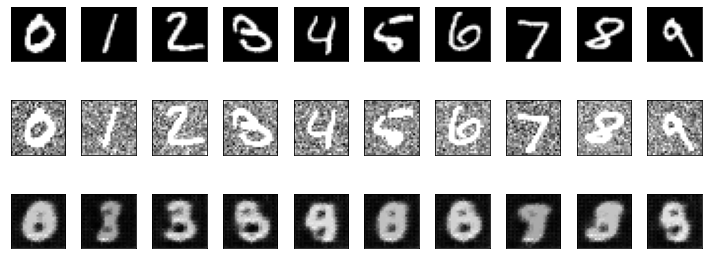

EPOCH 4/25

 EPOCH 4/25 	 train loss 0.044 	 val loss 0.062
0 => pnsr  :11.887, ssim :0.223437
1 => pnsr  :12.356, ssim :0.066869
2 => pnsr  :11.114, ssim :0.167763
3 => pnsr  :11.637, ssim :0.226050
4 => pnsr  :12.904, ssim :0.183838
5 => pnsr  :10.086, ssim :0.100864
6 => pnsr  :11.532, ssim :0.177006
7 => pnsr  :11.740, ssim :0.098129
8 => pnsr  :11.491, ssim :0.169341
9 => pnsr  :12.005, ssim :0.092198


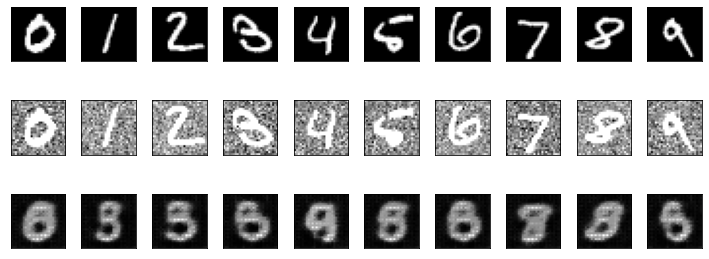

EPOCH 5/25

 EPOCH 5/25 	 train loss 0.037 	 val loss 0.046
0 => pnsr  :13.701, ssim :0.402420
1 => pnsr  :13.980, ssim :0.174662
2 => pnsr  :11.664, ssim :0.254724
3 => pnsr  :12.347, ssim :0.338103
4 => pnsr  :14.771, ssim :0.305715
5 => pnsr  :10.714, ssim :0.164500
6 => pnsr  :11.552, ssim :0.231500
7 => pnsr  :14.113, ssim :0.273667
8 => pnsr  :11.657, ssim :0.213236
9 => pnsr  :13.352, ssim :0.211539


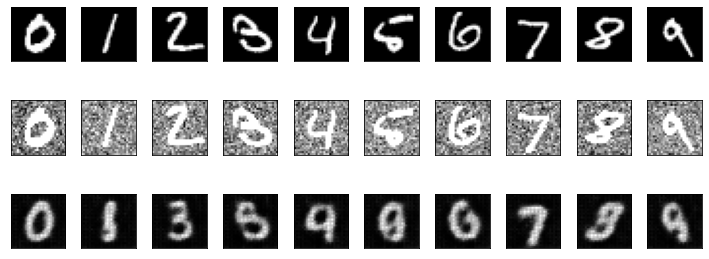

EPOCH 6/25

 EPOCH 6/25 	 train loss 0.034 	 val loss 0.039
0 => pnsr  :12.583, ssim :0.370868
1 => pnsr  :17.896, ssim :0.323968
2 => pnsr  :11.295, ssim :0.256052
3 => pnsr  :11.615, ssim :0.308681
4 => pnsr  :14.078, ssim :0.342410
5 => pnsr  :11.371, ssim :0.253690
6 => pnsr  :9.954, ssim :0.108964
7 => pnsr  :14.155, ssim :0.333343
8 => pnsr  :11.054, ssim :0.204782
9 => pnsr  :13.159, ssim :0.294655


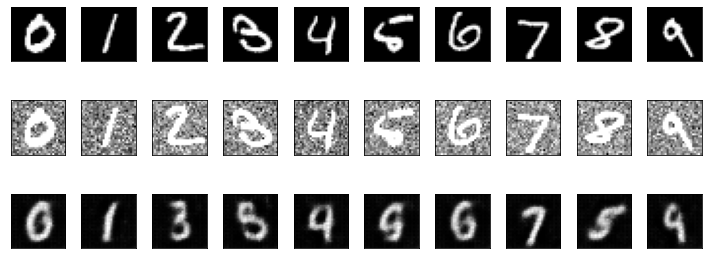

EPOCH 7/25

 EPOCH 7/25 	 train loss 0.032 	 val loss 0.033
0 => pnsr  :12.122, ssim :0.414957
1 => pnsr  :17.923, ssim :0.363858
2 => pnsr  :11.397, ssim :0.287364
3 => pnsr  :10.256, ssim :0.224417
4 => pnsr  :13.877, ssim :0.384395
5 => pnsr  :10.641, ssim :0.217025
6 => pnsr  :9.913, ssim :0.138245
7 => pnsr  :14.129, ssim :0.375343
8 => pnsr  :10.897, ssim :0.255273
9 => pnsr  :12.378, ssim :0.281992


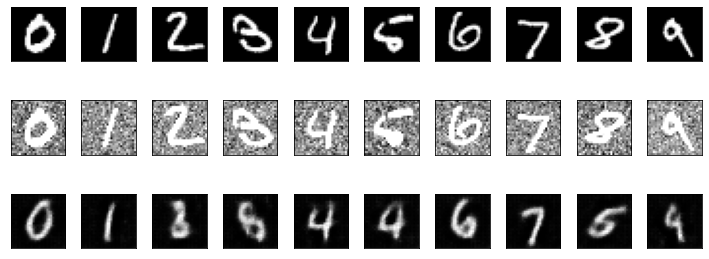

EPOCH 8/25

 EPOCH 8/25 	 train loss 0.032 	 val loss 0.033
0 => pnsr  :8.769, ssim :0.155675
1 => pnsr  :18.422, ssim :0.492492
2 => pnsr  :9.944, ssim :0.215041
3 => pnsr  :8.866, ssim :0.183237
4 => pnsr  :10.992, ssim :0.183875
5 => pnsr  :9.562, ssim :0.153695
6 => pnsr  :9.492, ssim :0.096574
7 => pnsr  :12.656, ssim :0.406011
8 => pnsr  :9.686, ssim :0.169969
9 => pnsr  :11.739, ssim :0.244330


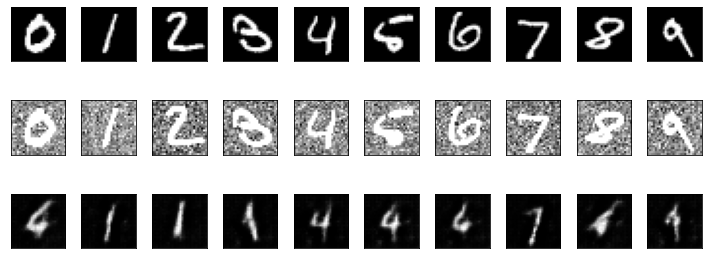

EPOCH 9/25

 EPOCH 9/25 	 train loss 0.031 	 val loss 0.031
0 => pnsr  :11.277, ssim :0.364094
1 => pnsr  :18.491, ssim :0.511774
2 => pnsr  :10.730, ssim :0.309519
3 => pnsr  :9.526, ssim :0.215844
4 => pnsr  :11.759, ssim :0.306787
5 => pnsr  :10.635, ssim :0.254476
6 => pnsr  :9.186, ssim :0.091490
7 => pnsr  :12.884, ssim :0.401404
8 => pnsr  :10.555, ssim :0.289345
9 => pnsr  :12.005, ssim :0.331449


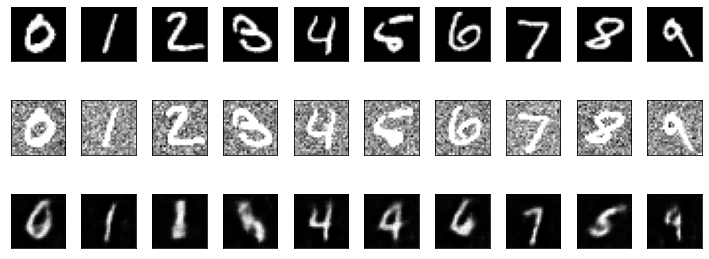

EPOCH 10/25

 EPOCH 10/25 	 train loss 0.031 	 val loss 0.031
0 => pnsr  :11.324, ssim :0.391280
1 => pnsr  :18.378, ssim :0.554761
2 => pnsr  :10.680, ssim :0.321928
3 => pnsr  :9.121, ssim :0.203102
4 => pnsr  :11.792, ssim :0.308375
5 => pnsr  :10.596, ssim :0.267353
6 => pnsr  :9.377, ssim :0.117638
7 => pnsr  :13.581, ssim :0.491645
8 => pnsr  :10.680, ssim :0.299137
9 => pnsr  :12.041, ssim :0.340384


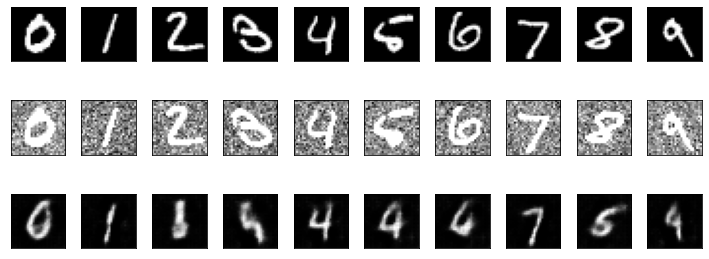

EPOCH 11/25

 EPOCH 11/25 	 train loss 0.030 	 val loss 0.032
0 => pnsr  :11.378, ssim :0.418811
1 => pnsr  :19.484, ssim :0.609239
2 => pnsr  :10.774, ssim :0.349135
3 => pnsr  :9.742, ssim :0.254616
4 => pnsr  :12.897, ssim :0.458523
5 => pnsr  :10.820, ssim :0.304703
6 => pnsr  :9.319, ssim :0.143867
7 => pnsr  :14.355, ssim :0.540417
8 => pnsr  :10.842, ssim :0.325972
9 => pnsr  :11.373, ssim :0.325637


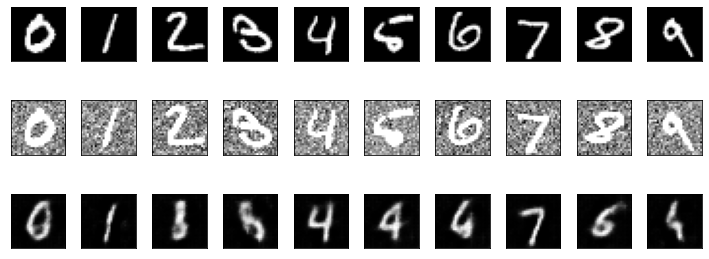

EPOCH 12/25

 EPOCH 12/25 	 train loss 0.030 	 val loss 0.029
0 => pnsr  :10.934, ssim :0.374220
1 => pnsr  :18.585, ssim :0.644361
2 => pnsr  :10.178, ssim :0.325249
3 => pnsr  :8.997, ssim :0.240909
4 => pnsr  :11.363, ssim :0.318507
5 => pnsr  :10.302, ssim :0.260093
6 => pnsr  :9.463, ssim :0.144677
7 => pnsr  :13.518, ssim :0.560574
8 => pnsr  :10.161, ssim :0.270707
9 => pnsr  :11.709, ssim :0.335797


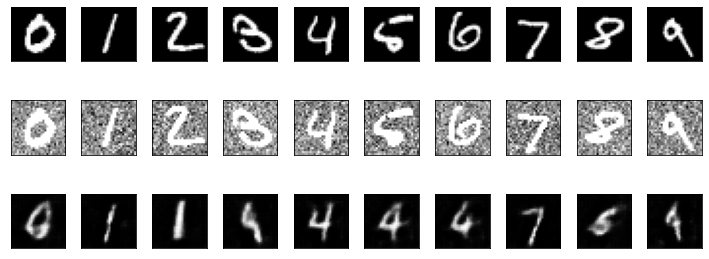

EPOCH 13/25

 EPOCH 13/25 	 train loss 0.030 	 val loss 0.029
0 => pnsr  :11.149, ssim :0.412529
1 => pnsr  :17.279, ssim :0.602734
2 => pnsr  :10.332, ssim :0.324751
3 => pnsr  :9.045, ssim :0.258509
4 => pnsr  :11.972, ssim :0.415541
5 => pnsr  :10.592, ssim :0.294446
6 => pnsr  :8.971, ssim :0.142873
7 => pnsr  :13.820, ssim :0.584987
8 => pnsr  :10.331, ssim :0.303568
9 => pnsr  :11.515, ssim :0.349189


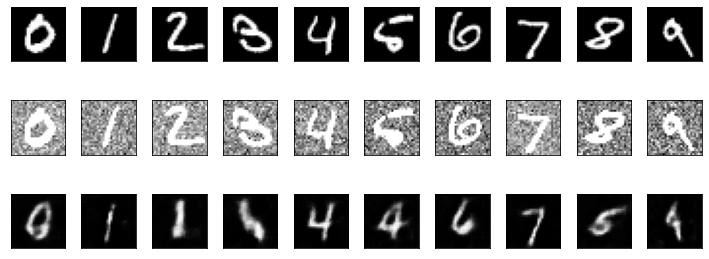

EPOCH 14/25

 EPOCH 14/25 	 train loss 0.030 	 val loss 0.029
0 => pnsr  :11.437, ssim :0.470957
1 => pnsr  :19.262, ssim :0.685058
2 => pnsr  :10.861, ssim :0.382801
3 => pnsr  :9.945, ssim :0.312210
4 => pnsr  :11.734, ssim :0.389495
5 => pnsr  :11.029, ssim :0.356840
6 => pnsr  :9.479, ssim :0.201682
7 => pnsr  :14.735, ssim :0.641468
8 => pnsr  :10.743, ssim :0.399295
9 => pnsr  :11.248, ssim :0.384721


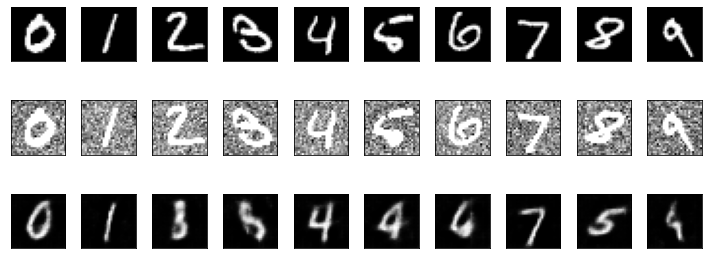

EPOCH 15/25

 EPOCH 15/25 	 train loss 0.029 	 val loss 0.029
0 => pnsr  :11.105, ssim :0.465243
1 => pnsr  :17.699, ssim :0.656277
2 => pnsr  :10.364, ssim :0.354391
3 => pnsr  :8.863, ssim :0.267393
4 => pnsr  :12.243, ssim :0.438288
5 => pnsr  :10.517, ssim :0.321297
6 => pnsr  :8.929, ssim :0.174333
7 => pnsr  :13.540, ssim :0.589290
8 => pnsr  :10.375, ssim :0.357721
9 => pnsr  :11.151, ssim :0.384403


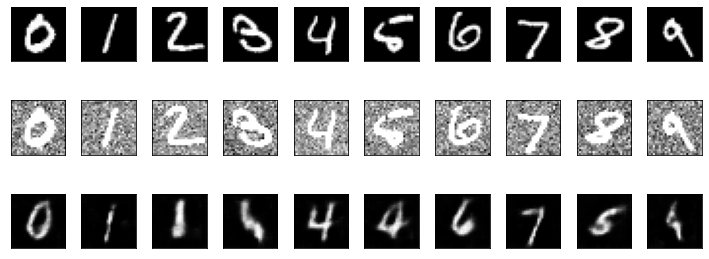

EPOCH 16/25

 EPOCH 16/25 	 train loss 0.029 	 val loss 0.029
0 => pnsr  :10.590, ssim :0.393298
1 => pnsr  :17.687, ssim :0.673613
2 => pnsr  :10.225, ssim :0.353398
3 => pnsr  :8.914, ssim :0.260422
4 => pnsr  :11.380, ssim :0.341241
5 => pnsr  :10.515, ssim :0.322841
6 => pnsr  :9.162, ssim :0.187136
7 => pnsr  :12.974, ssim :0.555180
8 => pnsr  :10.187, ssim :0.335924
9 => pnsr  :11.498, ssim :0.399618


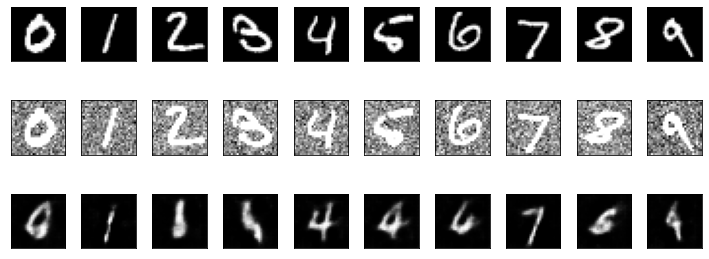

EPOCH 17/25

 EPOCH 17/25 	 train loss 0.029 	 val loss 0.030
0 => pnsr  :11.535, ssim :0.523274
1 => pnsr  :18.379, ssim :0.670474
2 => pnsr  :11.329, ssim :0.444600
3 => pnsr  :10.423, ssim :0.355982
4 => pnsr  :11.675, ssim :0.417471
5 => pnsr  :11.289, ssim :0.431215
6 => pnsr  :9.598, ssim :0.239757
7 => pnsr  :14.699, ssim :0.664551
8 => pnsr  :11.002, ssim :0.456065
9 => pnsr  :11.711, ssim :0.446437


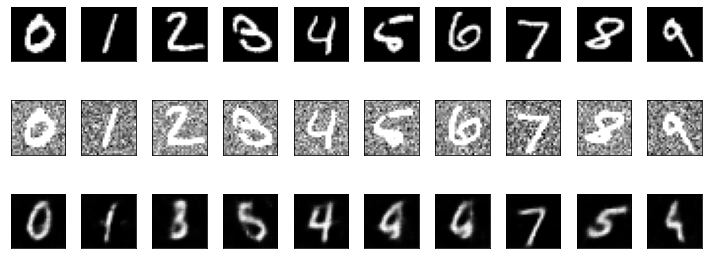

EPOCH 18/25

 EPOCH 18/25 	 train loss 0.029 	 val loss 0.029
0 => pnsr  :11.510, ssim :0.528993
1 => pnsr  :18.681, ssim :0.707025
2 => pnsr  :11.026, ssim :0.431089
3 => pnsr  :10.671, ssim :0.393990
4 => pnsr  :12.523, ssim :0.476447
5 => pnsr  :11.072, ssim :0.407932
6 => pnsr  :9.368, ssim :0.257012
7 => pnsr  :13.929, ssim :0.619412
8 => pnsr  :10.823, ssim :0.455759
9 => pnsr  :11.412, ssim :0.443431


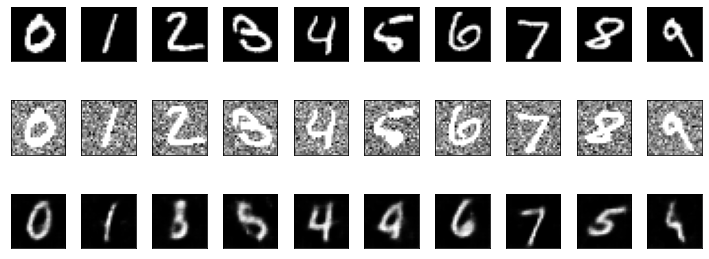

EPOCH 19/25

 EPOCH 19/25 	 train loss 0.029 	 val loss 0.031
0 => pnsr  :12.242, ssim :0.582363
1 => pnsr  :19.409, ssim :0.735473
2 => pnsr  :10.883, ssim :0.432180
3 => pnsr  :9.950, ssim :0.332379
4 => pnsr  :13.125, ssim :0.533499
5 => pnsr  :11.320, ssim :0.445970
6 => pnsr  :9.405, ssim :0.272362
7 => pnsr  :14.036, ssim :0.639428
8 => pnsr  :11.011, ssim :0.471249
9 => pnsr  :12.315, ssim :0.502336


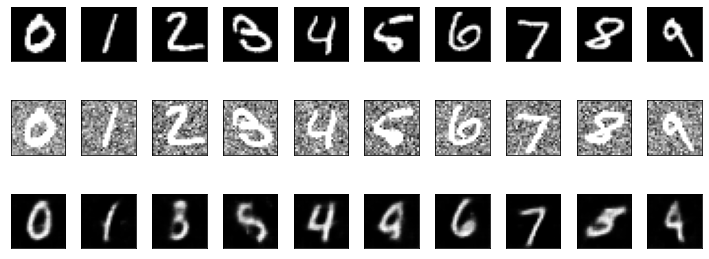

EPOCH 20/25

 EPOCH 20/25 	 train loss 0.029 	 val loss 0.029
0 => pnsr  :11.906, ssim :0.547735
1 => pnsr  :18.153, ssim :0.693544
2 => pnsr  :10.777, ssim :0.413728
3 => pnsr  :10.189, ssim :0.359441
4 => pnsr  :13.212, ssim :0.526005
5 => pnsr  :11.051, ssim :0.408029
6 => pnsr  :9.889, ssim :0.282470
7 => pnsr  :13.744, ssim :0.619949
8 => pnsr  :10.485, ssim :0.418694
9 => pnsr  :11.786, ssim :0.471180


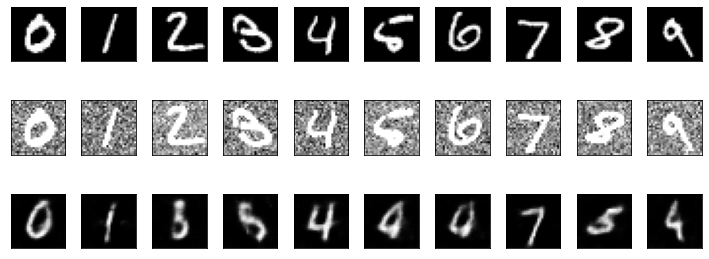

EPOCH 21/25

 EPOCH 21/25 	 train loss 0.028 	 val loss 0.028
0 => pnsr  :10.455, ssim :0.433923
1 => pnsr  :17.572, ssim :0.668701
2 => pnsr  :10.303, ssim :0.390099
3 => pnsr  :9.118, ssim :0.309196
4 => pnsr  :12.057, ssim :0.437302
5 => pnsr  :10.411, ssim :0.342957
6 => pnsr  :9.448, ssim :0.249917
7 => pnsr  :11.997, ssim :0.492516
8 => pnsr  :9.987, ssim :0.328102
9 => pnsr  :11.656, ssim :0.460223


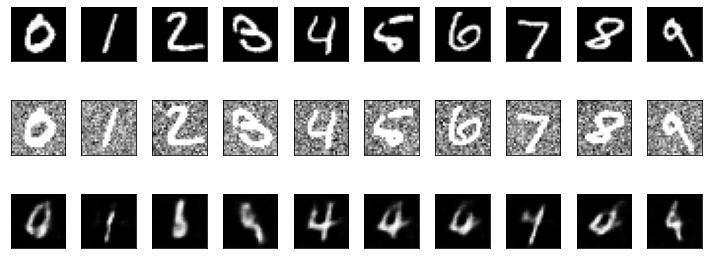

EPOCH 22/25

 EPOCH 22/25 	 train loss 0.028 	 val loss 0.029
0 => pnsr  :10.864, ssim :0.512558
1 => pnsr  :17.962, ssim :0.659262
2 => pnsr  :10.694, ssim :0.420722
3 => pnsr  :10.221, ssim :0.367043
4 => pnsr  :13.774, ssim :0.561034
5 => pnsr  :10.668, ssim :0.375607
6 => pnsr  :9.977, ssim :0.290432
7 => pnsr  :13.579, ssim :0.597661
8 => pnsr  :10.211, ssim :0.371609
9 => pnsr  :11.539, ssim :0.467277


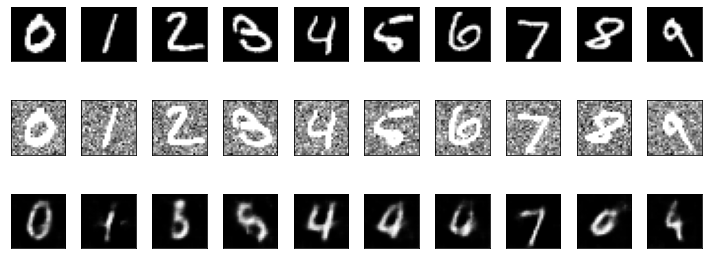

EPOCH 23/25

 EPOCH 23/25 	 train loss 0.028 	 val loss 0.032
0 => pnsr  :12.096, ssim :0.598554
1 => pnsr  :17.511, ssim :0.707723
2 => pnsr  :10.657, ssim :0.428009
3 => pnsr  :10.433, ssim :0.393491
4 => pnsr  :13.872, ssim :0.588264
5 => pnsr  :11.239, ssim :0.453963
6 => pnsr  :9.970, ssim :0.300165
7 => pnsr  :15.391, ssim :0.702790
8 => pnsr  :10.958, ssim :0.480136
9 => pnsr  :13.442, ssim :0.597073


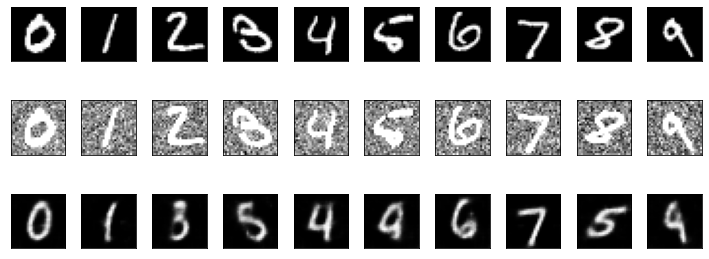

EPOCH 24/25

 EPOCH 24/25 	 train loss 0.028 	 val loss 0.028
0 => pnsr  :10.512, ssim :0.443546
1 => pnsr  :17.990, ssim :0.687840
2 => pnsr  :10.200, ssim :0.394091
3 => pnsr  :9.189, ssim :0.330259
4 => pnsr  :12.179, ssim :0.449094
5 => pnsr  :10.390, ssim :0.345266
6 => pnsr  :9.738, ssim :0.279523
7 => pnsr  :12.564, ssim :0.526035
8 => pnsr  :10.011, ssim :0.345078
9 => pnsr  :11.554, ssim :0.449230


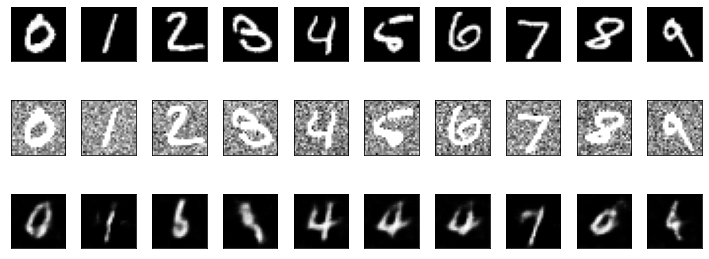

EPOCH 25/25

 EPOCH 25/25 	 train loss 0.028 	 val loss 0.028
0 => pnsr  :11.056, ssim :0.493113
1 => pnsr  :18.419, ssim :0.737728
2 => pnsr  :10.639, ssim :0.428457
3 => pnsr  :9.461, ssim :0.354595
4 => pnsr  :12.773, ssim :0.516251
5 => pnsr  :10.813, ssim :0.406874
6 => pnsr  :9.587, ssim :0.252101
7 => pnsr  :13.544, ssim :0.612643
8 => pnsr  :10.285, ssim :0.378823
9 => pnsr  :11.798, ssim :0.468482


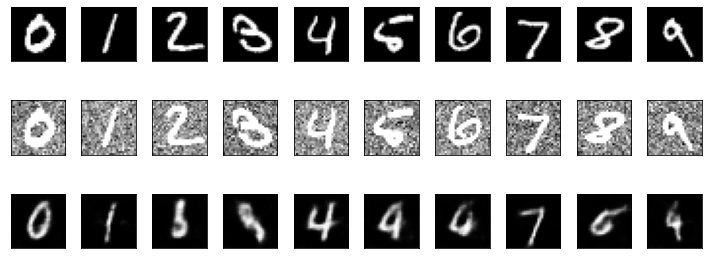

In [19]:
for epoch in range(num_epochs): #training하면서 몇 번의 epoch때 마다 검증데이터로 오차율?을 계산한다. 실제로 보정까지 하는지는 확인필요??
    print('EPOCH %d/%d' % (epoch + 1, num_epochs))
    ### Training (use the training function)
    train_loss=AE_train_epoch_den(
        encoder=encoder, 
        decoder=decoder, 
        device=device,
        dataloader=train_loader, 
        dataloader_hat=Custom_Gn_strong_train_loader,
        loss_fn=loss_fn, 
        optimizer=optim) 

  
    val_loss = AE_test_epoch_den( 
        encoder=encoder, 
        decoder=decoder, 
        device=device, 
        dataloader=valid_loader, 
        dataloader_hat=Custom_Gn_strong_val_loader,
        loss_fn=loss_fn) #여기도 noise_factor 변경 필요
    # Print Validationloss
    history_da['train_loss'].append(train_loss)
    history_da['val_loss'].append(val_loss)

    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    plot_ae_outputs_den(encoder, decoder)

In [20]:
#After training
AE_test_epoch_den(encoder, decoder, device, dataloader,dataloader_hat, loss_fn).item()

NameError: ignored